# Simulating Random Variables with Inverse Transform Sampling

In studying the transformation of random variables in [All of Statistics](http://www.stat.cmu.edu/~larry/all-of-statistics/) and working on a [few](/ml/hw/all-of-statistics-ch2-cdf-proof/) [related](/ml/hw/all-of-statistics-ch2-problem-04/) [exercises](/ml/hw/all-of-statistics-ch2-problem-08/) I've been in search of bigger picture motivation and a very cool result finally clicked: that we can simulate samples from any distribution by applying its inverse CDF to samples taken from a uniform random variable. (Note: technically this only works when the CDF has a closed form inverse function). Or in plainer terms, how can we transform results `math.random()` to simulate draws from another distribution?

## Transformation of Random Variables

Let's consider how to take the transformation of a random variable $X$ with cumulative distribution function $F_X(x)$. Let $Y = r(X)$, that is, $Y$ is the transformation of $X$ via function $r(X)$. 

To get the CDF of $Y$ we use the definition of CDFs:

$F_Y(y) = P(Y \leq y) = P(r(X) \leq y)$

We have $F_X(x)$ and want to know how to compute $F_Y(y)$ in terms of $F_X(x)$. To get there we can take the inverse of $r(x)$ on both sides of the inequality:

$F_Y(y) = P(Y \leq y) = P(r(X) \leq y) = P(X \leq r^{-1}(y))$

hey, that kind of looks like the CDF of $X$: 

$P(X \leq r^{-1}(y)) = F_X(r^{-1}(y))$

and that's how we get $F_Y(y)$ in terms of $F_X(x)$. We can compute the density function $f_y(y)$ by differentiating $F_Y(y)$, applying the chain rule:

$f_y(y) = f_y(r^{-1}(y)) \times \frac{d}{dy} r^{-1}(y)\mathop{dy}$

Note that it is only this simple if $r(x)$ is one-to-one and strictly monotone increasing; it gets more complicated to reason about the regions where $Y$ is defined otherwise, but this hopefully provides the background for why we use with the inverse of the CDF.


## Transforming a Uniform Random Variable

Getting back to the "cool result" I mentioned earlier, let's put this to use to show how we can take samples from other distributions if all we have available is a random number generator. [Random number generation](http://www.eg.bucknell.edu/~xmeng/Course/CS6337/Note/master/node36.html) is a whole other topic, but you are likely familiar with a `random` function available in most languages that will give you a number between 0 and 1. This can be viewed as a function that will give you samples from a uniform random variable in the range 0 to 1.

So we have a uniform random variable $U$ and another distribution $X$ with CDF $F$ that we'd like to draw samples from. If we'd like to be able to get $X$ as a function of $F$ and $U$, we need to work backwards and use the *inverse* of $F$ as the transformation function of $U$, so that when we apply the inverse of the inverse we get back to $X$:

$F_X(x) = P(F^{-1}(U) \leq x) = P(U \leq F(x)) = F_U(F_X(x))$ 

$F_U(F(x)) =
\begin{cases}
0 & F(x) < 0 \\\
F(x) & 0 \leq F(x) \leq 1 \\\
1 & F(x) > 1
\end{cases}
$

Note that $F(x)$, being a CDF, can only take ranges from 0 to 1, so this collapses to just:

$F_X(x) = F_U(F(x)) = F(x)$ wherever $F(x)$ is defined, so $X \sim F$.

Now that we've established that $X = F^{-1}(U)$, let's put it to use in code.

## Sampling from Uniform

First, let's plot a histogram of samples from the $U(0, 1)$:


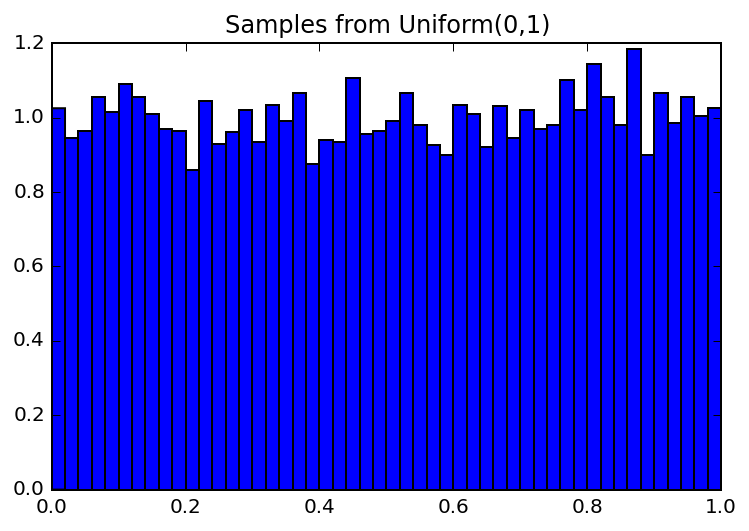

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import matplotlib.pyplot as plt

plt.hist([random.random() for i in range(10000)], 50, normed=True)
plt.title('Samples from Uniform(0,1)')
None

yep, that looks pretty uniform. 

## Sampling from an Exponential Distribution

Now let's say we want to sample from an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) to simulate the interval between requests hitting a web server (or see [plenty of other examples](https://www.probabilitycourse.com/chapter11/11_1_2_basic_concepts_of_the_poisson_process.php) of where this function might come in handy).

The exponential distribution has CDF:

$F_X(x) = 1 - e^{-\lambda x}$

following the plan outlined above, we can create our own exponential sampling function based on the random number generator if we can compute the CDF's inverse:

$1 - e^{-\lambda x} = y$
<br>$e^{-\lambda x} = 1 - y$
<br>$-\lambda x = ln(1 - y)$
<br>$x = \frac{-1}{\lambda}ln(1 - y)$

so 

$F^{-1}_X(x) = \frac{-1}{\lambda}ln(1 - x)$

Applying this inverse function to a sample taken from our random number generator should do the trick. Let's write this function and plot its histogram.

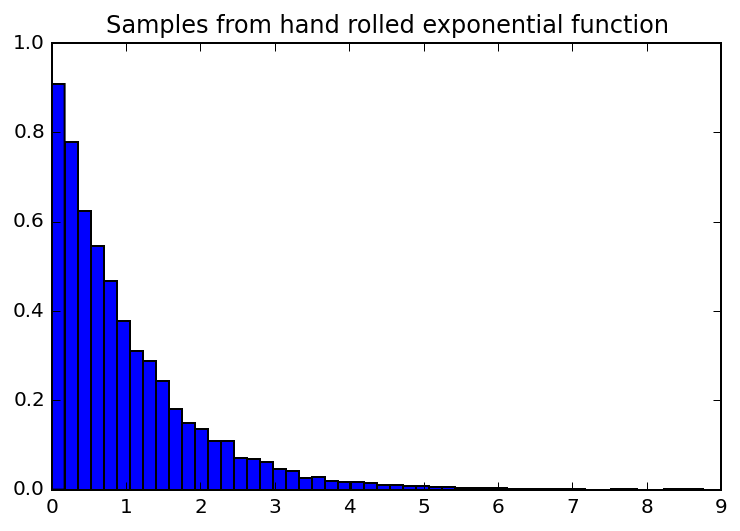

In [2]:
import math

def my_exp(lmbda=1.0):
    return (-1 / lmbda)*math.log(1 - random.random())

plt.hist([my_exp() for i in range(10000)], 50, normed=True)
plt.title('Samples from hand rolled exponential function')
None

and just to make sure this looks right, let's use `numpy`'s exponential function and compare:

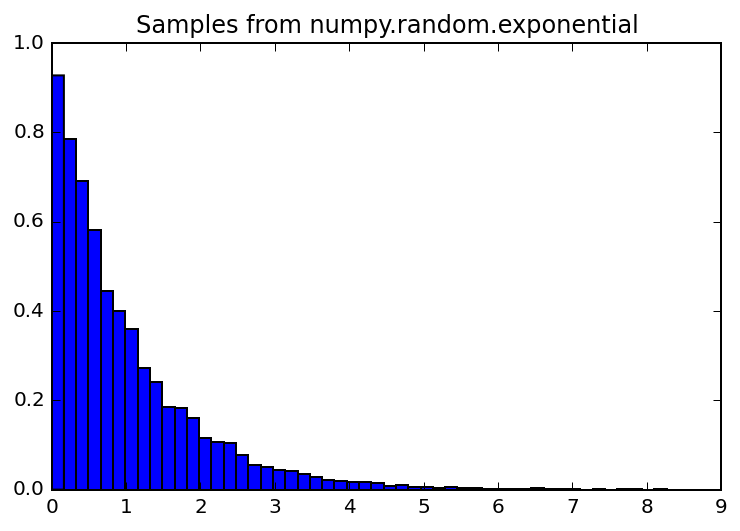

In [3]:
import numpy.random

plt.hist([numpy.random.exponential() for i in range(10000)], 50, normed=True)   
plt.title('Samples from numpy.random.exponential')
None

Looking good.

## Why does this work?

To get some intuition as to why this works, picture a cumulative distribution function and imagine taking a random point on the Y axis and seeing where it intersects the CDF.

Here's a plot of where 0.7 intersects the CDF for the Exponential distribution:


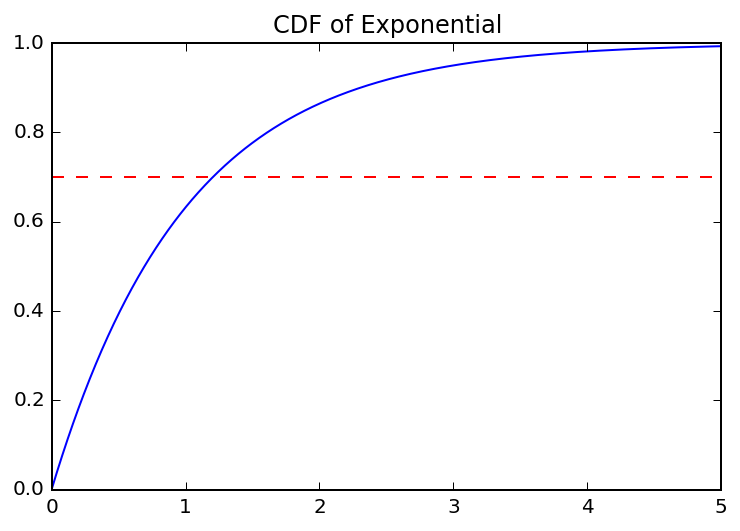

In [4]:
import numpy as np
from scipy.stats import expon

x = np.arange(0, 5, 0.005)
plt.plot(x, expon.cdf(x))
plt.plot(x, [0.7 for el in x], 'r--')
plt.title('CDF of Exponential')
None

this is exactly what it means to take the inverse; where the dotted line intersects is $F^{-1}(0.7)$. 

So with a random number generator in hand, we can randomly start on the Y axis and use a random variable's inverse CDF function to get back to a point sampled according to its distribution.

Further reading:
- [Notes on transformation of random variables](http://math.arizona.edu/~jwatkins/f-transform.pdf)
- [Notes on generating RVs](http://www.eg.bucknell.edu/~xmeng/Course/CS6337/Note/master/node48.html)
- [Excellent Quora answer providing further intuition](https://www.quora.com/What-is-an-intuitive-explanation-of-inverse-transform-sampling-method-in-statistics-and-how-does-it-relate-to-cumulative-distribution-function/answer/Amit-Sharma-2?srid=X8V)